In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [5]:
def make_mask(data, match, target_column):
    if match == "All":
        return np.ones(len(data), dtype=bool)
    return data[target_column] == match

In [19]:
def page_count_percentage(data, sort=True):
    """ Get page count percentage across subscription types """
    results = []
    
    for plan in data["subscription_type"].unique():
        mask = make_mask(data, plan, "subscription_type")
        user_journeys = split_pages(data[mask])
        page_counts = pd.Series([page for journey in user_journeys for page in journey]).value_counts()
        
        # Convert to percentage
        total_visits = page_counts.sum()
        page_counts = (page_counts / total_visits) * 100
        
        df_counts = pd.DataFrame({"Page": page_counts.index, "Percentage": page_counts.values, "Subscription Type": plan})
        results.append(df_counts)

    return pd.concat(results).reset_index(drop=True).sort_values(by="Percentage", ascending=False) if sort else pd.concat(results)


In [20]:
def page_presence_percentage(data, sort=True):
    """ Get page presence percentage across subscription types """
    results = []
    
    for plan in data["subscription_type"].unique():
        mask = make_mask(data, plan, "subscription_type")
        user_journeys = split_pages(data[mask])
        presence = pd.Series([page for journey in user_journeys for page in set(journey)]).value_counts()
        
        # Convert to percentage
        total_presences = presence.sum()
        presence = (presence / total_presences) * 100
        
        df_presence = pd.DataFrame({"Page": presence.index, "Percentage": presence.values, "Subscription Type": plan})
        results.append(df_presence)

    return pd.concat(results).reset_index(drop=True).sort_values(by="Percentage", ascending=False) if sort else pd.concat(results)


In [12]:
def page_destinations(data, plan="All"):
    mask = make_mask(data, plan, "subscription_type")
    user_journeys = split_pages(data[mask])
    transitions = {}
    for journey in user_journeys:
        for i in range(len(journey) - 1):
            src, dest = journey[i], journey[i + 1]
            transitions[(src, dest)] = transitions.get((src, dest), 0) + 1
    df_transitions = pd.DataFrame([(k[0], k[1], v) for k, v in transitions.items()], columns=["Page", "Next Page", "Count"])
    return df_transitions

In [8]:
# Load preprocessed data
preprocessed_file_path = "user_journey_preprocessed.csv"
# Load preprocessed data
df = pd.read_csv(preprocessed_file_path)

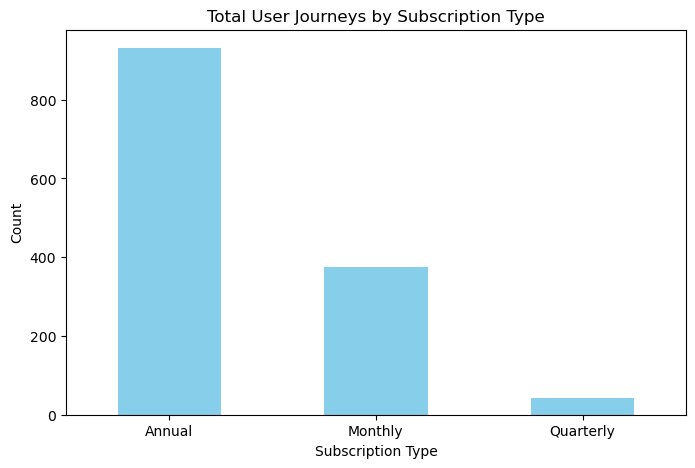

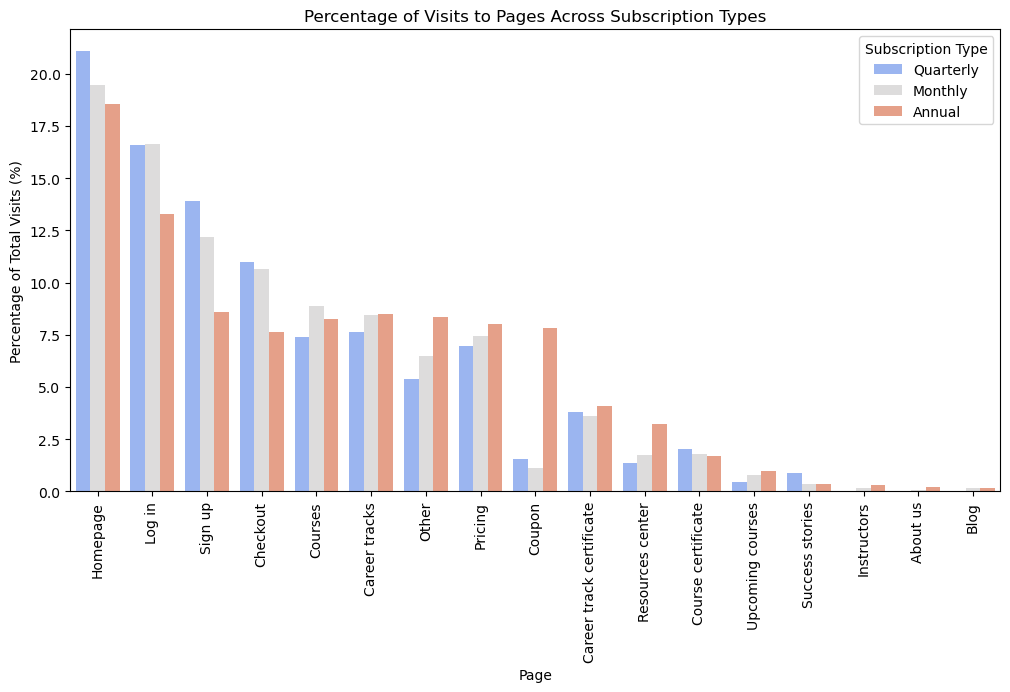

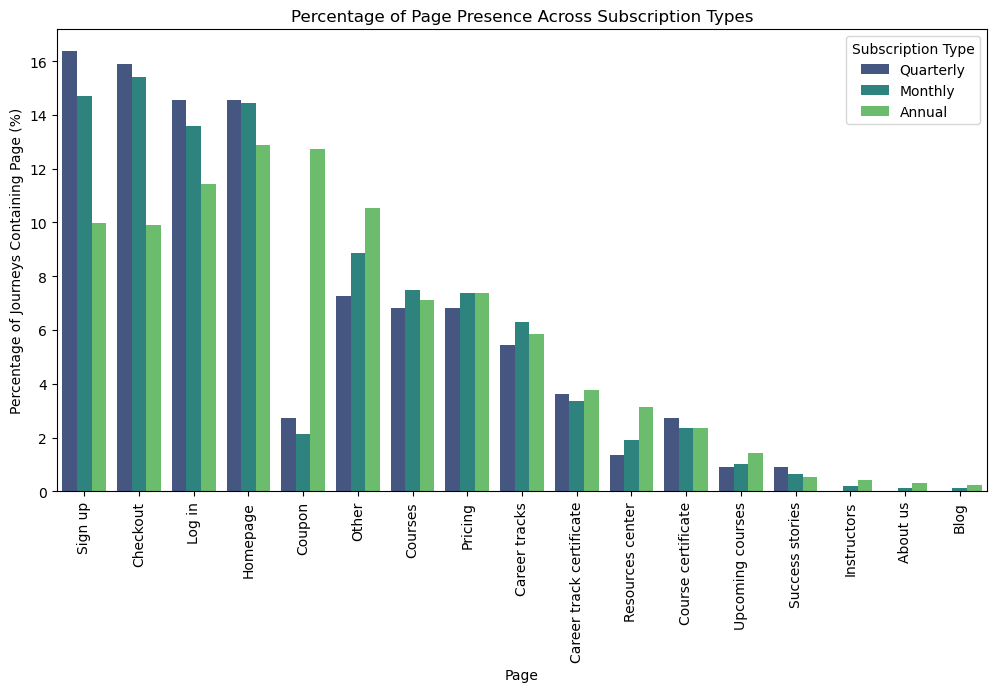

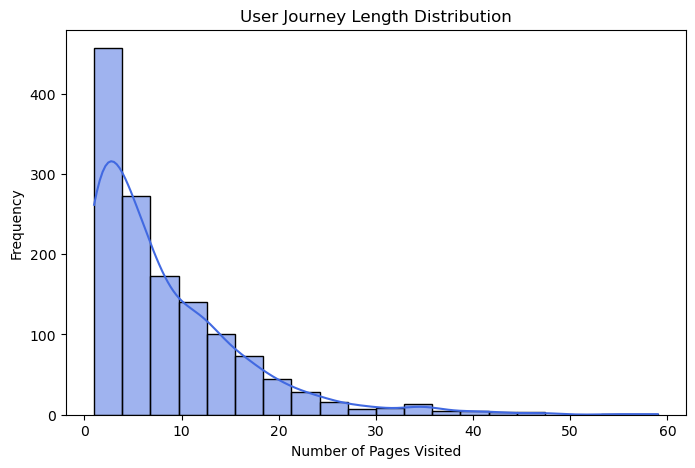

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7752\9050148.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7752\9050148.py:53: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 1200x600 with 0 Axes>

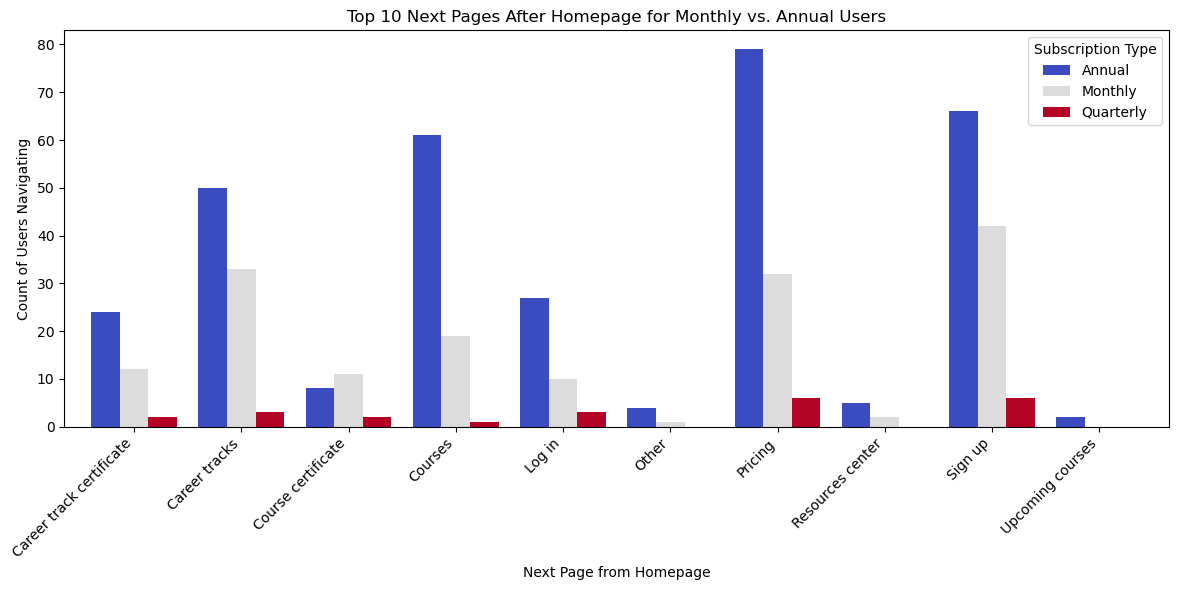

In [22]:
# 1. Total Journeys & Page Views by Subscription Type
plt.figure(figsize=(8, 5))
df.groupby("subscription_type")["user_journey"].count().plot(kind="bar", color='skyblue')
plt.title("Total User Journeys by Subscription Type")
plt.ylabel("Count")
plt.xlabel("Subscription Type")
plt.xticks(rotation=0)
plt.show()

# 1. Page Count Distribution Across Subscription Types
page_counts_df = page_count_percentage(df)

plt.figure(figsize=(12, 6))
sns.barplot(data=page_counts_df, x="Page", y="Percentage", hue="Subscription Type", palette="coolwarm")
plt.title("Percentage of Visits to Pages Across Subscription Types")
plt.ylabel("Percentage of Total Visits (%)")
plt.xlabel("Page")
plt.xticks(rotation=90)
plt.legend(title="Subscription Type")
plt.show()

# 2. Page Presence Analysis Across Subscription Types
page_presence_df = page_presence_percentage(df)

plt.figure(figsize=(12, 6))
sns.barplot(data=page_presence_df, x="Page", y="Percentage", hue="Subscription Type", palette="viridis")
plt.title("Percentage of Page Presence Across Subscription Types")
plt.ylabel("Percentage of Journeys Containing Page (%)")
plt.xlabel("Page")
plt.xticks(rotation=90)
plt.legend(title="Subscription Type")
plt.show()

# 5. User Journey Length Distribution
df["journey_length"] = df["user_journey"].apply(lambda x: len(x.split("-")))
plt.figure(figsize=(8, 5))
sns.histplot(df["journey_length"], bins=20, kde=True, color="royalblue")
plt.title("User Journey Length Distribution")
plt.xlabel("Number of Pages Visited")
plt.ylabel("Frequency")
plt.show()

# 6. Improved Next Page After Homepage for Monthly vs. Annual Users
df_home_transitions = df[df["user_journey"].str.startswith("Homepage")]

# Extract the first transition (Homepage → Next Page)
df_home_transitions["next_page"] = df_home_transitions["user_journey"].apply(lambda x: x.split("-")[1] if "-" in x else "None")

# Count occurrences per subscription type
df_home_transitions = df_home_transitions.groupby(["subscription_type", "next_page"]).size().reset_index(name="Count")

# Keep only top 10 next pages per subscription type for readability
df_top_transitions = df_home_transitions.groupby("subscription_type").apply(lambda x: x.nlargest(10, "Count")).reset_index(drop=True)

# Pivot the data for better visualization
df_pivot = df_top_transitions.pivot(index="next_page", columns="subscription_type", values="Count").fillna(0)

# Plot the fixed visualization
plt.figure(figsize=(12, 6))
df_pivot.plot(kind="bar", figsize=(12,6), colormap="coolwarm", width=0.8)
plt.title("Top 10 Next Pages After Homepage for Monthly vs. Annual Users")
plt.xlabel("Next Page from Homepage")
plt.ylabel("Count of Users Navigating")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Subscription Type")
plt.tight_layout()
plt.show()